## Контрольная работа CVDL, 24.10.22
Вам необходимо обучить многоклассовый классификатор изображений на train части датасета, находящегося в DATASET_PATH.
Также надо проверить что обучение сошлось, и замерять метрики на test.

Баллы:
 - работающий код тренировки с правильным лоссом и головой для задачи многоклассовой классификации: **4** балла
 - метрики precision/recall по классам по train и test: **2** балла
 - график train и test лоссов: **2** балла
 - отсутствие оверфита (по графикам train-test): **2** балла
 
Предполагается, что вы используете предобученную модель и затюните ее. Датасеты train и тест маленькие, всего по  2500 изображений, так что обучение сети с нуля приведет скорее всего к оверфиту.

In [1]:
from pathlib import Path

#######
DATASET_PATH = '/home/alexander/computerScience/phystech/9sem/abbyy/GroceryStoreDataset/dataset'
#######

DATASET_PATH = Path(DATASET_PATH)
assert DATASET_PATH.exists()

In [2]:
# если не установлено - установить pandas
#! pip install pandas

In [3]:
import pandas

In [4]:
import torch
import numpy as np
from tqdm import tqdm

In [5]:
from torchvision.datasets.folder import DatasetFolder, default_loader
from typing import Optional, Callable, Tuple, Any, List
import pandas as pd


class FoodDataset(DatasetFolder):    
    def __init__(self,
            root: str,
            classes_path: str,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            ):
        super().__init__(root=root, transform=transform, loader=default_loader, target_transform=target_transform, extensions='')
        self.root = Path(root)
        self._image_paths = self.find_images_recursively(self.root)
        self._classes_map = pd.read_csv(classes_path).set_index('Class Name (str)')['Coarse Class Name (str)']
        self._image_labels = [self.determine_sample_label(self.root, ip) for ip in self._image_paths]
        self.classes = list(dict.fromkeys(self._classes_map))
        self.samples = [
            (sample_path, self.classes.index(sample_cls))
            for (sample_path, sample_cls) in zip(self._image_paths, self._image_labels)
        ]
    
    def find_images_recursively(self, root_path):
        files = list(root_path.glob("[!.]*"))
        samples = list(f for f in files if not f.is_dir())
        subdirs = list(f for f in files if f.is_dir())
        assert len(samples) == 0 or len(subdirs) == 0, f"Can't mix subdirs and images"
        if len(subdirs):
            samples = []
            for sub_root_path in subdirs:
                samples += self.find_images_recursively(sub_root_path)
        return samples
    
    def determine_sample_label(self, root_path, sample_path):
        parts = sample_path.relative_to(root_path).parent.parts
        precise_label = parts[-1]
        coarse_label = self._classes_map[precise_label]
        return coarse_label

In [6]:
ds_train = FoodDataset(DATASET_PATH / 'train', DATASET_PATH / 'classes.csv')
ds_test = FoodDataset(DATASET_PATH / 'test', DATASET_PATH / 'classes.csv')
print(len(ds_train), len(ds_test))

2640 2485


In [7]:
ds_train.classes == ds_test.classes

True

Pear


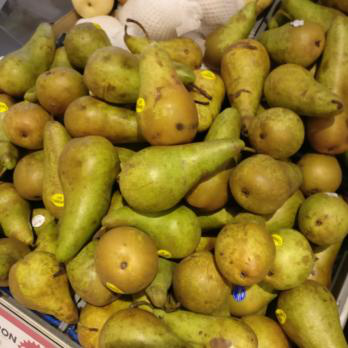

In [8]:
img, cls_idx = ds_train[750]
print(ds_train.classes[cls_idx])
img

### Подготовка к тренировке

In [9]:
N_CLASSES = len(ds_train.classes)

In [10]:
import torchvision.transforms as transforms

In [11]:
target_transform = lambda x: torch.Tensor([x]).long()[0]

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        transforms.Resize((224, 224)),
    ]
)


Трансформы можно менять - например, можно добавить аугментации

In [14]:
train_transform = test_transform


In [15]:
ds_train = FoodDataset(DATASET_PATH / 'train', DATASET_PATH / 'classes.csv', transform=train_transform, target_transform=target_transform)
ds_test = FoodDataset(DATASET_PATH / 'test', DATASET_PATH / 'classes.csv', transform=test_transform, target_transform=target_transform)

In [16]:
trainloader = torch.utils.data.DataLoader(
    ds_train, batch_size=32, shuffle=True, num_workers=4
)
testloader = torch.utils.data.DataLoader(
    ds_test, batch_size=32, shuffle=False, num_workers=4
)

### Построение модели
Используйте не слишком тяжелую pretrained-модель, заморозьте ее и добавьте голову на N классов.

Важно помнить, что для некоторых слоев поведение в train/eval режимах - разное, и от этого зависит "успешность" тюнинга.

In [17]:
import torchvision
import torch.nn as nn

In [207]:
mobilenet = torchvision.models.mobilenet_v3_small(weights='IMAGENET1K_V1')

total_params = sum(
	param.numel() for param in mobilenet.parameters()
)
print(total_params)

for param in mobilenet.parameters():
    param.requires_grad = False

mobilenet.classifier = nn.Sequential(nn.Dropout(p=0.2), nn.Linear(576, N_CLASSES, bias=True))

total_params = sum(
	param.numel() for param in mobilenet.parameters()
)
print(total_params)

net = mobilenet

2542856
951819


## Лосс

In [208]:
criterion = nn.CrossEntropyLoss()

## Тренировка

Для легкого backbone с замороженными весами на batch=32 скорость train ~ 10 батчей в секунду, а в эпохе ~ 80 батчей.

Тренировка в 50 эпох займет 80batch / 10batch/s * 50ep * 2 \[train + test\] = 800s ~13min 

In [209]:
from sklearn.metrics import precision_score, recall_score, f1_score

class PrecisionRecall(nn.Module):
    def forward(self, input_prob: torch.Tensor, target: torch.Tensor):
        input_cls = torch.argmax(input_prob, dim=1, keepdims=True).detach().cpu()
        target = target.detach().cpu()
        precision = precision_score(target, input_cls, average='micro')
        recall = recall_score(target, input_cls, average='micro')

        return precision, recall

In [210]:
metric = PrecisionRecall()

In [211]:
def run_1_epoch(net, optimizer, dataloader, criterion, device=None, log_freq=10):
    loss_logs = []
    precision = []
    recall = []
    is_training = net.training

    for num, (x, y) in tqdm(enumerate((iter(dataloader)))):
        x, y = x.to(device), y.to(device)
        yp = net(x)
        loss_val = criterion(yp, y)
        prec, rec = metric(yp, y)


        if is_training:
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

        if num % log_freq == 0:
            loss_logs.append(loss_val.mean().detach().cpu().item())
            precision.append(prec)
            recall.append(rec)

    return np.mean(loss_logs), np.mean(precision), np.mean(recall)


def train(net, optimizer, train_dataloader, test_dataloader, criterion, num_epochs, device):
    stats = {"train": [], "val": []}
    for e in range(num_epochs):
        print(f'Epoch {e}:')
        print(f"Training:")
        net.train()
        epoch_stats = run_1_epoch(net, optimizer, train_dataloader, criterion, device, log_freq=1)
        print(epoch_stats)
        stats["train"].append(epoch_stats)

        print(f"Validating:")
        net.eval()
        epoch_stats = run_1_epoch(net, optimizer, test_dataloader, criterion, device, log_freq=1)
        stats["val"].append(epoch_stats)
        print(epoch_stats)


    return stats

In [212]:
gpu = torch.device('cuda')
net = net.to(gpu)
opt = torch.optim.Adam(net.parameters(), lr=3e-5)

In [213]:
N_epochs = 30

In [214]:
res = train(net=net, optimizer=opt, train_dataloader=trainloader, test_dataloader=testloader, criterion=criterion, num_epochs=N_epochs, device=gpu)

Epoch 0:
Training:


83it [00:08,  9.35it/s]

(3.699516721518643, 0.08772590361445783, 0.08772590361445783)
Validating:



78it [00:08,  9.47it/s]

(3.760833813593938, 0.006009615384615385, 0.006009615384615385)
Epoch 1:
Training:



83it [00:08,  9.70it/s]

(3.6053999533136207, 0.14834337349397592, 0.14834337349397592)
Validating:



78it [00:08,  9.21it/s]

(3.7518162391124625, 0.11057692307692307, 0.11057692307692307)
Epoch 2:
Training:



83it [00:09,  8.59it/s]

(3.545828216047172, 0.14871987951807228, 0.14871987951807228)
Validating:



78it [00:09,  8.53it/s]

(3.7395366644247985, 0.11057692307692307, 0.11057692307692307)
Epoch 3:
Training:



83it [00:09,  8.44it/s]

(3.4926552858697364, 0.14871987951807228, 0.14871987951807228)
Validating:



78it [00:09,  8.54it/s]

(3.7245496969956617, 0.11057692307692307, 0.11057692307692307)
Epoch 4:
Training:



83it [00:09,  8.54it/s]

(3.4582336494721564, 0.1592620481927711, 0.1592620481927711)
Validating:



78it [00:09,  8.30it/s]

(3.7076163567029514, 0.11057692307692307, 0.11057692307692307)
Epoch 5:
Training:



83it [00:09,  8.66it/s]

(3.4273999570363975, 0.15060240963855423, 0.15060240963855423)
Validating:



78it [00:09,  8.09it/s]

(3.688150506753188, 0.11057692307692307, 0.11057692307692307)
Epoch 6:
Training:



83it [00:10,  8.23it/s]

(3.39644732532731, 0.1588855421686747, 0.1588855421686747)
Validating:



78it [00:09,  8.07it/s]

(3.6650347037193103, 0.11057692307692307, 0.11057692307692307)
Epoch 7:
Training:



83it [00:10,  7.99it/s]

(3.3703621037035103, 0.1566265060240964, 0.1566265060240964)
Validating:



78it [00:10,  7.78it/s]

(3.6195844381283493, 0.11258012820512821, 0.11258012820512821)
Epoch 8:
Training:



83it [00:10,  8.23it/s]

(3.347701322601502, 0.16265060240963855, 0.16265060240963855)
Validating:



78it [00:09,  8.53it/s]

(3.5175780088473587, 0.1340430402930403, 0.1340430402930403)
Epoch 9:
Training:



83it [00:09,  8.85it/s]

(3.332992188901786, 0.1558734939759036, 0.1558734939759036)
Validating:



78it [00:09,  8.46it/s]

(3.4220551344064565, 0.1478937728937729, 0.1478937728937729)
Epoch 10:
Training:



83it [00:09,  8.63it/s]

(3.3126228774886535, 0.16528614457831325, 0.16528614457831325)
Validating:



78it [00:09,  8.19it/s]

(3.3741441048108616, 0.16033272283272285, 0.16033272283272285)
Epoch 11:
Training:



83it [00:09,  8.74it/s]

(3.298542189310832, 0.16076807228915663, 0.16076807228915663)
Validating:



78it [00:09,  8.58it/s]

(3.35459602643282, 0.16212606837606838, 0.16212606837606838)
Epoch 12:
Training:



83it [00:09,  8.84it/s]

(3.2818517426410354, 0.16603915662650603, 0.16603915662650603)
Validating:



78it [00:08,  8.85it/s]

(3.3405926197003097, 0.1643391330891331, 0.1643391330891331)
Epoch 13:
Training:



83it [00:09,  9.05it/s]

(3.2747583504182747, 0.16340361445783133, 0.16340361445783133)
Validating:



78it [00:08,  8.70it/s]

(3.3305284411479263, 0.1643391330891331, 0.1643391330891331)
Epoch 14:
Training:



83it [00:09,  9.03it/s]

(3.250664492687547, 0.16114457831325302, 0.16114457831325302)
Validating:



78it [00:09,  8.00it/s]

(3.3205630901532297, 0.16514041514041514, 0.16514041514041514)
Epoch 15:
Training:



83it [00:10,  8.08it/s]


(3.245776883090835, 0.15775602409638553, 0.15775602409638553)
Validating:


78it [00:09,  7.84it/s]

(3.3116308190883736, 0.16874618437118438, 0.16874618437118438)
Epoch 16:
Training:



83it [00:09,  8.72it/s]

(3.2364335950598657, 0.16829819277108435, 0.16829819277108435)
Validating:



78it [00:09,  8.54it/s]

(3.302113646116012, 0.1685363247863248, 0.1685363247863248)
Epoch 17:
Training:



83it [00:09,  8.66it/s]

(3.223262577171785, 0.16265060240963855, 0.16265060240963855)
Validating:



78it [00:09,  8.15it/s]

(3.294376105834276, 0.1707493894993895, 0.1707493894993895)
Epoch 18:
Training:



83it [00:09,  8.52it/s]

(3.2097422387226517, 0.17131024096385541, 0.17131024096385541)
Validating:



78it [00:09,  8.46it/s]

(3.286173566793784, 0.1723519536019536, 0.1723519536019536)
Epoch 19:
Training:



83it [00:10,  8.16it/s]

(3.1992575978658286, 0.16829819277108435, 0.16829819277108435)
Validating:



78it [00:09,  7.93it/s]

(3.2793417404859495, 0.17115003052503053, 0.17115003052503053)
Epoch 20:
Training:



83it [00:10,  8.23it/s]

(3.18509598812425, 0.17281626506024098, 0.17281626506024098)
Validating:



78it [00:10,  7.63it/s]


(3.272116800149282, 0.17034874847374848, 0.17034874847374848)
Epoch 21:
Training:


83it [00:10,  7.97it/s]

(3.1863504892372223, 0.16792168674698796, 0.16792168674698796)
Validating:



78it [00:09,  8.54it/s]

(3.265883817122533, 0.17195131257631258, 0.17195131257631258)
Epoch 22:
Training:



83it [00:09,  8.72it/s]

(3.175658570714744, 0.1720632530120482, 0.1720632530120482)
Validating:



78it [00:09,  8.27it/s]

(3.260020633538564, 0.17315323565323565, 0.17315323565323565)
Epoch 23:
Training:



83it [00:09,  8.54it/s]

(3.172867499202131, 0.17131024096385541, 0.17131024096385541)
Validating:



78it [00:09,  8.49it/s]

(3.254087053812467, 0.17355387667887667, 0.17355387667887667)
Epoch 24:
Training:



83it [00:09,  8.56it/s]

(3.163609947066709, 0.16453313253012047, 0.16453313253012047)
Validating:



78it [00:08,  8.72it/s]

(3.250125226302025, 0.17315323565323565, 0.17315323565323565)
Epoch 25:
Training:



83it [00:09,  8.69it/s]

(3.15463725342808, 0.1690512048192771, 0.1690512048192771)
Validating:



78it [00:09,  8.27it/s]

(3.245588461558024, 0.1739545177045177, 0.1739545177045177)
Epoch 26:
Training:



83it [00:10,  8.25it/s]

(3.1472463033285485, 0.17356927710843373, 0.17356927710843373)
Validating:



78it [00:09,  8.49it/s]

(3.2414060662954283, 0.17475579975579977, 0.17475579975579977)
Epoch 27:
Training:



83it [00:09,  8.51it/s]

(3.137531309242708, 0.16980421686746988, 0.16980421686746988)
Validating:



78it [00:09,  8.32it/s]

(3.236885307691036, 0.17435515873015875, 0.17435515873015875)
Epoch 28:
Training:



83it [00:09,  8.38it/s]

(3.130840910486428, 0.1686746987951807, 0.1686746987951807)
Validating:



78it [00:09,  8.44it/s]

(3.2322522906156688, 0.17435515873015875, 0.17435515873015875)
Epoch 29:
Training:



83it [00:09,  8.44it/s]

(3.1362754063433913, 0.16566265060240964, 0.16566265060240964)
Validating:



78it [00:09,  8.40it/s]


(3.2291909792484383, 0.17475579975579977, 0.17475579975579977)


In [215]:
val_logs = res['val']
train_logs = res['train']

val_loss = [i[0] for i in val_logs]
train_loss = [i[0] for i in train_logs]

val_precision = [i[1] for i in val_logs]
train_precision = [i[1] for i in train_logs]

val_recall = [i[2] for i in val_logs]
train_recall = [i[2] for i in train_logs]

## Метрики и лосс

In [216]:
net.eval()
test_stats = run_1_epoch(net, opt, testloader, criterion, gpu)
test_stats

78it [00:08,  8.71it/s]


(3.388994127511978, 0.12109375, 0.12109375)

In [217]:
print(f"Train Precision/Recall: {[np.mean(train_precision), np.mean(train_recall)]}, \nTest Precision/Recall {[test_stats[1], test_stats[2]]}")

Train Precision/Recall: [0.16059236947791164, 0.16059236947791164], 
Test Precision/Recall [0.12109375, 0.12109375]


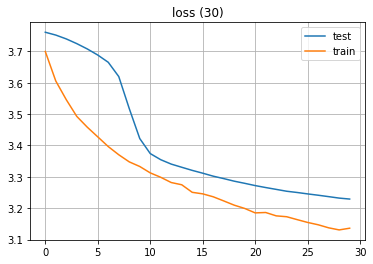

In [218]:
from matplotlib import pyplot as plt
plt.plot(np.arange(len(val_loss)), val_loss, label='test')
plt.plot(np.arange(len(train_loss)), train_loss, label='train')

plt.title(f'loss ({N_epochs})')
plt.grid()
plt.legend()


### Окружение
Список пакетов в python виртуальной машины

In [7]:
! nvidia-smi

Mon Nov  1 20:02:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000001:00:00.0 Off |                    0 |
| N/A   49C    P8    28W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
! cat /etc/lsb-release

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=18.04
DISTRIB_CODENAME=bionic
DISTRIB_DESCRIPTION="Ubuntu 18.04.6 LTS"


In [4]:
! python -V

Python 3.8.11


In [14]:
! pip list

Package                     Version     Editable project location
--------------------------- ----------- --------------------------------------------
aiohttp                     3.8.3
aiohttp-retry               2.8.3
aiosignal                   1.2.0
amqp                        5.1.1
antlr4-python3-runtime      4.9.3
anyio                       3.6.1
appdirs                     1.4.4
argon2-cffi                 21.3.0
argon2-cffi-bindings        21.2.0
astroid                     2.12.10
asttokens                   2.0.8
async-timeout               4.0.2
asyncssh                    2.12.0
atpublic                    3.1.1
attrs                       22.1.0
Babel                       2.10.3
backcall                    0.2.0
beautifulsoup4              4.11.1
billiard                    3.6.4.0
black                       22.10.0
bleach                      5.0.1
brotlipy                    0.7.0
cachetools                  5.2.0
celery                      5.2.7
certifi              


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip
